# Задача о распределении инвестиций 

# Постановка задачи
Совет директоров фирмы изучает предложения по модернизации $n$ предприятий.
Для этих целей выделено $y_1$ миллионов долларов. Для каждого предприятия $j$ разработано несколько альтернативных проектов. Каждый из проектов характеризуется суммарными затратами $c_j$ и будущими доходами $R_j$ .Необходимо выбрать такие проекты для каждого предприятия,чтобы фирма получила максимальный годовой доход.

# Математическая постановка задачи

Имеется функционал вида $W=\sum\limits_{i=1}^{n}{R_i(x_i)}$. Требуется найти оптимальное управление (такое $\hat{x}=(\hat{x}_1,...,\hat{x}_n)\in X^n$, что функционал $W$ достигает максимума, то есть $\hat{W}=\sum\limits_{i=1}^{n}{R_i(\hat{x}_i)} = max _{x\in X^n}W(x)$) при ограничении $\sum\limits_{i=1}^n{c_i(\hat{x}_i})\leq y_1$ 

# Решение задачи

Обозначим через $f_1(y_1)$ макисмальный годовой доход, который будет получен от реализации проектов $x_1, ..., x_n$ (вместе они составляют управление в динамичесокй задаче) при заданном объеме инвестиций $y_1$ млн. долларов (этот параметр будет отвечать за состояние в динамической задаче).

Этот максимальный годовой доход можно расписать рекуррентным соотношением:
$$f_1(y_1)=\max_{x_1\in\{x_1:c_1(x_1)\leq y_1, x_1\in X\}}\{R_1(x_1)+f_2(y_1-c_1(x_1))\},$$
где $f_2(y_2)$ - макисмальный годовой доход, который будет получен от реализации проектов $x_2, ..., x_n$ при заданном объеме инвестиций $y_2=y_1-c_1(x_1)$ млн. долларов.

Аналогично для $f_2(y_2)$:
$$f_2(y_2)=\max_{x_2\in\{x_2:c_2(x_2)\leq y_2, x_2\in X\}}\{R_2(x_2)+f_3(y_2-c_2(x_2))\},$$
где $f_3(y_3)$ также обозначает макисмальный годовой доход при заданном объеме инвестиций $y_3=y_2-c_2(x_2)$ млн. долларов.

В конечном итоге уравнение Беллмана будет выглядеть следующим образом:
\begin{cases}
f_{n+1}=0,\\
f_i(y_i)=\max_{x_i\in\{x_i:c_i(x_i)\leq y_i, x_i\in X\}}\{R_i(x_i)+f_{i+1}(y_i-c_i(x_i))\},
\\i=n,n-1,..., 1.
\end{cases}

Таким образом сначала будем искать условно оптимальные управления, а после этого можно строить и оптимальные управления.

# Программная реализация

In [1]:
import pandas as pd
import numpy as np

In [2]:
manufactories = ['Предприятие 1', 'Предприятие 2', 'Предприятие 3', 'Предприятие 4']
columns = [
    [copy for manufactory in manufactories for copy in [manufactory]*2],
    [copy for i, variable in enumerate([('c', 'R')]*len(manufactories)) for copy in (variable[0]+str(i+1),variable[1]+str(i+1))]
]
placeholder = np.nan
investments = [[0, 1, placeholder], [0,3, placeholder], [0,3,5], [0,5,9], [0,1,2], [0,4,6], [0, 2, placeholder], [0,3,placeholder]]
data = [(*value[:-1], *value[-1]) for value in zip(*columns, investments)]
df = pd.DataFrame(data, columns = ['Предприятие', 'Параметр', 'План 1','План 2','План 3'])
df = df.set_index(['Предприятие', 'Параметр'])
df

План 1  План 2  План 3
Предприятие   Параметр                        
Предприятие 1 c1             0       1     NaN
              R1             0       3     NaN
Предприятие 2 c2             0       3     5.0
              R2             0       5     9.0
Предприятие 3 c3             0       1     2.0
              R3             0       4     6.0
Предприятие 4 c4             0       2     NaN
              R4             0       3     NaN

In [3]:
def get_table(y, c, R, f, placeholder = -1):
    """
    Строит таблицу с возможными значениями годового дохода
    Args:
        y: вектор инвестиций
        c: вектор затрат на каждый проект
        R: вектор ежегодной прибыли
        f: значения максимального ежегодного дохода на прошлом шаге
        placeholder: заглушка для ячеек таблицы, где нет значения
    Returns:
        np.array: таблица с подсчитанными значениями годового дохода в зависимости от y и с
    """
    table = np.subtract.outer(np.arange(5+1), c)
    table = np.where(table>=0, table, np.nan)
    table = np.where(np.isnan(table), placeholder, table).astype(np.int32)
    result = np.where((table>=0), R+f[table], placeholder)
    return result.astype(np.int32)

def solve_dynamically(df, y, placeholder = -1):
    """
    Решает задачу о распределении инвестиций
    Args:
        df (pd.DataFrame): Таблица со значениями затрат и ежегодной прибыли для каждого предприятия
        y (int): Максимальное значение инвестиций
    """
    manufactories_number, plan_number = df.shape[0]//2, df.shape[1]
    f_i = np.zeros(y+1)
    tables, values, directions = [], [], []
    
    # 1. Цикл для каждого предприятия от 1 до n
    for i in range(manufactories_number, 0, -1):
        # 2. Строим таблицы для каждого предприятия (размер (y1, m), где m==y_i)
        c, R = df[2*(i-1):2*(i)].to_numpy()
        table = get_table(np.arange(y+1), c, R, f_i, placeholder)
        f_i, direction = table.max(axis=1), table.argmax(axis=1)
        tables.append(table)
        values.append(f_i)
        directions.append(direction)
    return tables, values, directions

In [4]:
tables, values, directions = solve_dynamically(df, 5)

In [11]:
tables[-1]

array([[ 0, -1, -1],
       [ 4,  3, -1],
       [ 6,  7, -1],
       [ 7,  9, -1],
       [ 9, 10, -1],
       [11, 12, -1]])

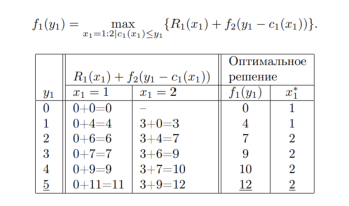

In [6]:
import cv2
import os
import matplotlib.pyplot as plt

img = cv2.imread(os.path.join('data', 'presentation_image(3).png'))
plt.imshow(img[:,:,::-1])
plt.axis(False)
print()

# Источники
* Н.П.Визгунов. Динамическое программирование в экономических задачах c применением системы MATLAB. Н.Новгород: ННГУ, 2006. 50 с.
* Вентцель Е.С. Исследование операций: задачи, принципы, методология. М. : КНОРУС, 2013. 192 с.
* Зенкевич Н. А., Губар Е. А. Практикум по исследованиям операций. М. : Золотое сечение, 2007. 170 с.